# Support Vector Machines (SVMs)

This notebook includes an implementation of SVMs using numpy and scipy. Scikit-learn is used for data generation.

## 1. Import packages

In [1]:
import numpy as np
import math
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn import datasets

## 2. Functions used in SVMs.

### 2.1 Kernel functions

In [2]:
def linear_kernel(x, y, **kwargs):
    """ Linear kernel function.
    This kernel simply returns the scalar product between the two points.
    This results in a linear separation.
    
    Parameters
    ----------
    x : np.ndarray
        Array of shape (M,1), i.e.: vector, where M is the number of features/dimensions in the
        assingment.
        
    y : np.ndarray
        Array of shape (M,1), i.e.: vector, where M is the number of features/dimensions in the
        assingment.
    
    kwargs : dict
        Contains parameters of the kernel. In the case of the linear kernel, it is an empty dict.
    
    Returns
    -------
    kernel_out : float
        Output of linear kernel - scalar product of vector x and y.
    """
    kernel_out = np.dot(x, y)
    return kernel_out

In [3]:
# Test case
test_case_threshold = 10e-4

x = np.array([1, -4, 4.5])
y = np.array([0.1, 2, 1])
kwargs = {}

# Test should be: -3.4

test = linear_kernel(x=x, y=y, **kwargs)

assert abs(test - (-3.4)) < test_case_threshold

In [4]:
def polynomial_kernel(x, y, **kwargs):
    """ Polynomial kernel function with polynomial degree p.
    This kernel allows for curved decision boundaries. The exponent p (a
    positive integer) controls the degree of the polynomials. p = 2 will make
    quadratic shapes (ellipses, parabolas, hyperbolas). Setting p = 3 or higher
    will result in more complex shapes.
    
    Parameters
    ----------
    x : np.ndarray
        Array of shape (M,1), i.e.: vector, where M is the number of features/dimensions in the
        assingment.
        
    y : np.ndarray
        Array of shape (M,1), i.e.: vector, where M is the number of features/dimensions in the
        assingment.
        
    
    kwargs : dict
        Contains parameters of the kernel. In the case of the polynomial kernel, it contains 
        p (type int) that is the polynomial degree of kernel function.
    
    Returns
    -------
    kernel_out : float
        Output of polynomial kernel.
    """
    p = kwargs["p"]
    kernel_out = np.power(np.dot(x, y) + 1, p)
    return kernel_out

In [5]:
# Test case
test_case_threshold = 10e-4

x = np.array([1, -4, 4.5])
y = np.array([0.1, 2, 1])
kwargs = {"p":4}

# Test should be: 33.1776

test = polynomial_kernel(x=x, y=y, **kwargs)

assert abs(test - (33.1776)) < test_case_threshold

In [6]:
def radial_basis_function_kernel(x, y, **kwargs):
    """ Radial Basis Function (RBF) kernel.
    This kernel uses the explicit euclidian distance between the two datapoints,
    and often results in very good boundaries. The parameter delta is used to
    control the smoothness of the boundary.
    
    Parameters
    ----------
    x : np.ndarray
        Array of shape (M,1), i.e.: vector, where M is the number of features/dimensions in the
        assingment.
        
    y : np.ndarray
        Array of shape (M,1), i.e.: vector, where M is the number of features/dimensions in the
        assingment.
        
    kwargs : dict
        Contains parameters of kernel. In the case of the Radial Basis Function (RBF) kernel, 
        it contains delta (type float) that is the parameter controlling the smoothness 
        of the decision boundary.
    
    Returns
    -------
    kernel_out : float
        Output of RBF kernel.
    """
    delta = kwargs["delta"]
    kernel_out = np.exp(-np.linalg.norm(np.subtract(x, y), 2) / (2 * np.power(delta, 2)))
    return kernel_out

In [7]:
# Test case
test_case_threshold = 10e-4

x = np.array([1, -4, 4.5])
y = np.array([0.1, 2, 1])
kwargs = {"delta": 2.5}

# Test should be: 0.5710

test = radial_basis_function_kernel(x=x, y=y, **kwargs)

assert abs(test - 0.5710) < test_case_threshold

### 2.2 Objective function

In [8]:
def pre_compute(inputs, targets, kernel, **kwargs):
    """ Pre-compute part of the objective function to speed up training.
    
    Parameters
    ----------
    inputs : np.ndarray
        Array of shape (N,M) where N is the number of data points and M is the 
        number of features (2 in the assingment).
        
    targets : np.ndarray
        Array of shape (N,1), i.e.: vector, where N is the number of data points in the
        assingment. Elements are either 1 or -1, signifying the true label of a data point.
        
    kernel : function
        The kernel function.
    
    kwargs : dict
        Contains parameters of the kernel. 
        In the case of the linear kernel, it is an empty dict.
        In the case of the polynomial kernel, it contains p (type int) that is the polynomial 
        degree of kernel function.
        In the case of the Radial Basis Function (RBF) kernel, it contains delta (type float) 
        that is the parameter controlling the smoothness of the decision boundary.
    
    Returns
    -------
    pre_computed : np.ndarray
        Matrix with the pre-computed values of shape (N,N).
    """
    N = inputs.shape[0]
    
    pre_computed = np.zeros((N,N))
    
    for i in range(N):
        for j in range(N):
            pre_computed[i][j] = targets[i] * targets[j] * kernel(x=inputs[i], y=inputs[j], **kwargs)
    
    return pre_computed


def objective_func(alpha):
    """ The objective function of the SVM that is minimized.
    
    Parameters
    ----------
    alpha : np.ndarray
        Array of shape (N,1), i.e.: vector, where N is the number of data points in the
        assingment. Alpha is the vector of Lagrange multipliers for each data point.
    
    Returns
    -------
    obj_min : float
        Output of objective function to be minimized.
        
    Notes
    -----
    To not optimize constants, the function uses global variables instead of passed in function arguments.
    Global variables: pre_computed.
    Only argument to be optimized is alpha.
    """
    N = alpha.shape[0]
    
    accumulator_core = 0
    accumulator_alpha = 0
    
    for i in range(N):
        accumulator_alpha = accumulator_alpha + alpha[i]
        
        for j in range(N):
            accumulator_core = accumulator_core + alpha[i] * alpha[j] * pre_computed[i][j]
    
    obj_min = 0.5 * accumulator_core - accumulator_alpha
    
    return obj_min

### 2.3 Optimizer arguments

In [9]:
def zero_fun(alpha):
    """ A constraint of the objective function of the SVM.
    
    Parameters
    ----------
    alpha : np.ndarray
        Array of shape (N,1), i.e.: vector, where N is the number of data points in the
        assingment. Alpha is the vector of Lagrange multipliers for each data point.
    
    targets : np.ndarray
        Array of shape (N,1), i.e.: vector, where N is the number of data points in the
        assingment. Elements are either 1 or -1, signifying the true label of a data point.
    
    Returns
    -------
    constraint : float
        Constraint expressed as the output of the function.
    """
    constraint = np.dot(alpha, targets)
    return constraint

In [11]:
def reduce_comp(inputs, targets, alpha, threshold=10e-5):
    """ Reduces computation inside the objective function via pre-computing an NxN matrix.
    
    Parameters
    ----------
    inputs : np.ndarray
        Array of shape (N,M) where N is the number of data points and M is the 
        number of features (2 in the assingment).
        
    targets : np.ndarray
        Array of shape (N,1), i.e.: vector, where N is the number of data points in the
        assingment. Elements are either 1 or -1, signifying the true label of a data point.
    
    alpha : np.ndarray
        Array of shape (N,1), i.e.: vector, where N is the number of data points in the
        assingment. Alpha is the vector of Lagrange multipliers for each data point.
        
    threshold : float
        Threshold for determining whether a Lagrange multiplier is 0 (i.e.: within the threshold value).
        Needed to find support vectors.
        
    Returns
    -------
    support_vecs : np.ndarray
        Array of support vectors of shape (N', M) where N' is the number of support vectors, 
        and M is the number of features. M is 2 in the assingment.
        
    support_vec_targets : np.ndarray
        Array of the support vector targets of shape (N', 1) where N' is the number of support vectors.
        
    support_vec_alpha : np.ndarray
        Array of the support vector alpha values (Lagrange multiplier values) of shape (N', 1) 
        where N' is the number of support vectors.
    """
    # Mask alpha values that are greater than zero (use a threshold).
    boolean_mask = threshold < alpha
    
    # Get the support vectors and their corresponding target and alpha values.
    support_vecs, support_vec_targets, support_vec_alpha = \
        inputs[boolean_mask], targets[boolean_mask], alpha[boolean_mask]
    
    return support_vecs, support_vec_targets, support_vec_alpha

### 2.4 Indicator function for classification

In [12]:
def indicator_func(new_input, support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs):
    """ Indicator function of SVM. This is the classifier of the SVM.
    
    Parameters
    ----------
    new_input : np.ndarray
        Array of shape (1,M) where M is the number of features (2 in the assingment).
        
    support_vecs : np.ndarray
        Array of support vectors of shape (N', M) where N' is the number of support vectors, 
        and M is the number of features. M is 2 in the assingment.
        
    support_vec_targets : np.ndarray
        Array of the support vector targets of shape (N', 1) where N' is the number of support vectors.
        
    support_vec_alpha : np.ndarray
        Array of the support vector alpha values (Lagrange multiplier values) of shape (N', 1) 
        where N' is the number of support vectors.v
        
    kernel : function
        The kernel function.
    
    kwargs : dict
        Contains parameters of the kernel. 
        In the case of the linear kernel, it is an empty dict.
        In the case of the polynomial kernel, it contains p (type int) that is the polynomial 
        degree of kernel function.
        In the case of the Radial Basis Function (RBF) kernel, it contains delta (type float) 
        that is the parameter controlling the smoothness of the decision boundary.
        
    Returns
    -------
    ind : float
        Indicator value, i.e.: classification, of the new data point new_input.
    """
    # Number of support vectors.
    N = support_vecs.shape[0]
    
    # Select a support vector at random to use for computing the bias.
    # Set random seed to always select the same bias! 
    np.random.seed(200)
    support_vec_indices = list(range(support_vecs.shape[0]))
    support_vec_idx = np.random.choice(support_vec_indices)
    support_vec = support_vecs[support_vec_idx]
    support_vec_target = support_vec_targets[support_vec_idx]
    
    # Compute bias term.
    b = 0
    for i in range(N):
        b = b + support_vec_alpha[i] * support_vec_targets[i] * kernel(support_vec, support_vecs[i], **kwargs)
    b = b - support_vec_target
    
    # Using the bias, comptue the indicator value.
    ind = 0
    for i in range(N):
        ind = ind + support_vec_alpha[i] * support_vec_targets[i] * kernel(new_input, support_vecs[i], **kwargs)
    ind = ind - b
    
    return ind
        

## 3. Simple problem, linearly separable data

### 3.1 Data generation

In [13]:
# Easy data
# Set random seed
np.random.seed(100)

# Create data classA.
classA = np.concatenate((np.random.randn(10, 2) * 0.2 + [1.5, 0.5], 
                         np.random.randn(10, 2) * 0.2 + [-1.5, 0.5]))

# Create data classB.
classB = np.random.randn(20, 2) * 0.2 + [0.0, -0.5]

# Concatenate classA and classB to get the input data.
inputs = np.concatenate((classA, classB))

# Set the labels/targets for each trainign data point. classA is label 1, classB is label -1.
targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))

# Get the number of training data points.
N = inputs.shape[0]

# Randomly reorder the data and the labels (same random ordering).
permute = list(range(N))
random.shuffle(permute)

inputs = inputs[permute, :]
targets = targets[permute]

### 3.2 Visualizing data

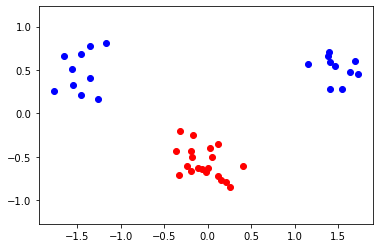

In [14]:
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

plt.axis("equal")
#plt.savefig("svmplot.pdf")
plt.show()

### 3.3 Training

In [16]:
# N is the number of training data points.
N = inputs.shape[0]

# Initialize the alpha vector with 0s.
start = np.zeros(N)

# Boundary conditions. Wihtout slack, there is only lower boundary.
C = None
B = [(0,C) for b in range(N)]

# Constraints.
XC = {'type':'eq', 'fun':zero_fun}

# Select the linear kernel for this simple problem.
kwargs = {}
kernel = linear_kernel

# Pre-compute the constant part of the objective function.
pre_computed = pre_compute(inputs=inputs, targets=targets, kernel=kernel, **kwargs)

# Optimize the alphas.
ret = minimize(objective_func, start, bounds=B, constraints=XC)

# Assert if optimizer converged to a solution.
assert ret['success'] == True, "Failed to fit model. Try a more complex model or more slack for this complex data."

# Retrieve alpha.
alpha = ret["x"]

# Extract the support vectors, their targets, and alpha values. 
support_vecs, support_vec_targets, support_vec_alpha = reduce_comp(inputs, targets, alpha)
print(f"{support_vecs.shape[0]} support vectors have been found.")

3 support vectors have been found.


### 3.4 Visualizing the decision boundary and a new data point

Classifer: 3.7444232375165165


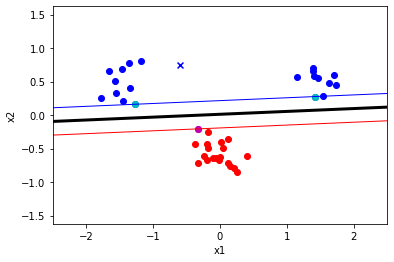

In [17]:
# Define new point and classify it using the indicator function.
new_input = np.array([-0.6, 0.75])
ind = indicator_func(new_input, support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
print(f"Classifer: {ind}")

# Set limits for the contour plot.
xlim = 2.5
ylim = 1.5

# Set the grid of the contour plot using the indicator function.
xgrid = np.linspace(-xlim, xlim)
ygrid = np.linspace(-ylim, ylim)
grid = np.array(
    [[indicator_func(np.array([x, y]), support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
    for x in xgrid] for y in ygrid])

# Plot the contour. classB (target is -1) is red, classA (target is 1) is blue.
plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

# Scatter plot the data.
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

# Retrive the support vectors for each class.
support_vecs_classA = support_vecs[support_vec_targets == 1]
support_vecs_classB = support_vecs[support_vec_targets == -1]

# Scatter plot the support vectors with the corresponding colours.
plt.scatter([p[0] for p in support_vecs_classA],[p[1] for p in support_vecs_classA], c="c", marker="o")
plt.scatter([p[0] for p in support_vecs_classB],[p[1] for p in support_vecs_classB], c="m", marker="o")

# Scatter plot the new data point with the correct colour.
plt.scatter(new_input[0], new_input[1], c="r" if ind < 0 else "b", marker="x", s=35)

# Set the axes to be of equal lenght.
plt.axis("equal")
plt.xlabel("x1")
plt.ylabel("x2")

# Save the figure.
#plt.savefig("svmplot.pdf")

# Plot the figure.
plt.show()

## 4. Slightly more difficult problem, data linearly not separable

### 4.1 Data generation

In [18]:
# Create data classA.
np.random.seed(105)

classA = np.concatenate((np.random.randn(10, 2) * 0.4 + [1.5, -0.5], 
                         np.random.randn(10, 2) * 0.4 + [-1.5, 0.5]))

# Create data classB.
classB = np.random.randn(20, 2) * 0.3 + [0.0, -0.9]

# Concatenate classA and classB to get the input data.
inputs = np.concatenate((classA, classB))

# Set the labels/targets for each trainign data point. classA is label 1, classB is label -1.
targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))

# Get the number of training data points.
N = inputs.shape[0]

# Randomly reorder the data and the labels (same random ordering).
permute = list(range(N))
random.shuffle(permute)

inputs = inputs[permute, :]
targets = targets[permute]

### 4.2 Visualizing data

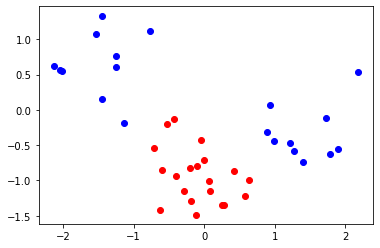

In [19]:
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

plt.axis("equal")
#plt.savefig("svmplot.pdf")
plt.show()

### 4.3.1 Training (linear model without slack fails)

In [20]:
# N is the number of training data points.
N = inputs.shape[0]

# Initialize the alpha vector with 0s.
start = np.zeros(N)

# Boundary conditions. Wihtout slack, there is only lower boundary.
B = [(0,None) for b in range(N)]

# Constraints.
XC = {'type':'eq', 'fun':zero_fun}

# Select the linear kernel for this simple problem.
kwargs = {}
kernel = linear_kernel

# Pre-compute the constant part of the objective function.
pre_computed = pre_compute(inputs=inputs, targets=targets, kernel=kernel, **kwargs)

# Optimize the alphas.
ret = minimize(objective_func, start, bounds=B, constraints=XC)

# Assert if optimizer converged to a solution.
assert ret['success'] == True, "Failed to fit model. Try a more complex model or more slack for this complex data."

# Retrieve alpha.
alpha = ret["x"]

# Extract the support vectors, their targets, and alpha values. 
support_vecs, support_vec_targets, support_vec_alpha = reduce_comp(inputs, targets, alpha)
print(f"{support_vecs.shape[0]} support vectors have been found.")

AssertionError: Failed to fit model. Try a more complex model or more slack for this complex data.

### 4.3.2 Training (optimization converges with slack)

In [23]:
# N is the number of training data points.
N = inputs.shape[0]

# Initialize the alpha vector with 0s.
start = np.zeros(N)

# Adding slack variables. Boundary conditions. Wiht slack, there is both a lower and upper boundary.
C = 5
B = [(0,C) for b in range(N)]

# Constraints.
XC = {'type':'eq', 'fun':zero_fun}

# Select the linear kernel for this simple problem.
kwargs = {}
kernel = linear_kernel

# Pre-compute the constant part of the objective function.
pre_computed = pre_compute(inputs=inputs, targets=targets, kernel=kernel, **kwargs)

# Optimize the alphas.
ret = minimize(objective_func, start, bounds=B, constraints=XC)

# Assert if optimizer converged to a solution.
assert ret['success'] == True, "Failed to fit model. Try a more complex model or more slack for this complex data."

# Retrieve alpha.
alpha = ret["x"]

# Extract the support vectors, their targets, and alpha values. 
support_vecs, support_vec_targets, support_vec_alpha = reduce_comp(inputs, targets, alpha)
print(f"{support_vecs.shape[0]} support vectors have been found.")

11 support vectors have been found.


### 4.3.3 Visualizing the decision boundary and a new data point

Classifer: 3.1941122269801316


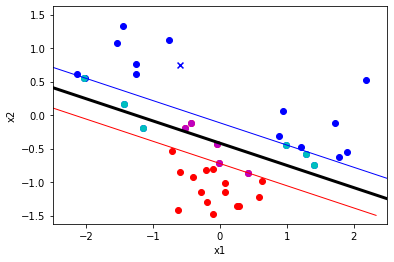

In [24]:
# Define new point and classify it using the indicator function.
new_input = np.array([-0.6, 0.75])
ind = indicator_func(new_input, support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
print(f"Classifer: {ind}")

# Set limits for the contour plot.
xlim = 2.5
ylim = 1.5

# Set the grid of the contour plot using the indicator function.
xgrid = np.linspace(-xlim, xlim)
ygrid = np.linspace(-ylim, ylim)
grid = np.array(
    [[indicator_func(np.array([x, y]), support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
    for x in xgrid] for y in ygrid])

# Plot the contour. classB (target is -1) is red, classA (target is 1) is blue.
plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

# Scatter plot the data.
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

# Retrive the support vectors for each class.
support_vecs_classA = support_vecs[support_vec_targets == 1]
support_vecs_classB = support_vecs[support_vec_targets == -1]

# Scatter plot the support vectors with the corresponding colours.
plt.scatter([p[0] for p in support_vecs_classA],[p[1] for p in support_vecs_classA], c="c", marker="o")
plt.scatter([p[0] for p in support_vecs_classB],[p[1] for p in support_vecs_classB], c="m", marker="o")

# Scatter plot the new data point with the correct colour.
plt.scatter(new_input[0], new_input[1], c="r" if ind < 0 else "b", marker="x", s=35)

# Set the axes to be of equal lenght.
plt.axis("equal")
plt.xlabel("x1")
plt.ylabel("x2")

# Save the figure.
#plt.savefig("svmplot.pdf")

# Plot the figure.
plt.show()

### 4.4.1 Training (optimization converges with more complex model)

In [25]:
# N is the number of training data points.
N = inputs.shape[0]

# Initialize the alpha vector with 0s.
start = np.zeros(N)

# Boundary conditions. Wihtout slack, there is only lower boundary.
B = [(0,None) for b in range(N)]

# Constraints.
XC = {'type':'eq', 'fun':zero_fun}

# Select the linear kernel for this simple problem.
kwargs = {"p": 2}
kernel = polynomial_kernel

# Pre-compute the constant part of the objective function.
pre_computed = pre_compute(inputs=inputs, targets=targets, kernel=kernel, **kwargs)

# Optimize the alphas.
ret = minimize(objective_func, start, bounds=B, constraints=XC)

# Assert if optimizer converged to a solution.
assert ret['success'] == True, "Failed to fit model. Try a more complex model or more slack for this complex data."

# Retrieve alpha.
alpha = ret["x"]

# Extract the support vectors, their targets, and alpha values. 
support_vecs, support_vec_targets, support_vec_alpha = reduce_comp(inputs, targets, alpha)
print(f"{support_vecs.shape[0]} support vectors have been found.")

5 support vectors have been found.


### 4.4.2 Visualizing the decision boundary and a new data point

Classifer: 0.23350503064352757


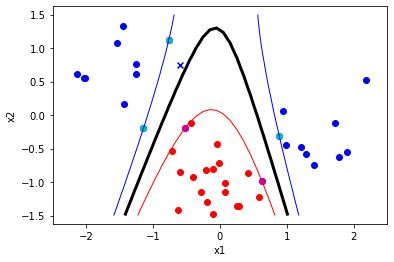

In [26]:
# Define new point and classify it using the indicator function.
new_input = np.array([-0.6, 0.75])
ind = indicator_func(new_input, support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
print(f"Classifer: {ind}")

# Set limits for the contour plot.
xlim = 2.5
ylim = 1.5

# Set the grid of the contour plot using the indicator function.
xgrid = np.linspace(-xlim, xlim)
ygrid = np.linspace(-ylim, ylim)
grid = np.array(
    [[indicator_func(np.array([x, y]), support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
    for x in xgrid] for y in ygrid])

# Plot the contour. classB (target is -1) is red, classA (target is 1) is blue.
plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

# Scatter plot the data.
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

# Retrive the support vectors for each class.
support_vecs_classA = support_vecs[support_vec_targets == 1]
support_vecs_classB = support_vecs[support_vec_targets == -1]

# Scatter plot the support vectors with the corresponding colours.
plt.scatter([p[0] for p in support_vecs_classA],[p[1] for p in support_vecs_classA], c="c", marker="o")
plt.scatter([p[0] for p in support_vecs_classB],[p[1] for p in support_vecs_classB], c="m", marker="o")

# Scatter plot the new data point with the correct colour.
plt.scatter(new_input[0], new_input[1], c="r" if ind < 0 else "b", marker="x", s=35)

# Set the axes to be of equal lenght.
plt.axis("equal")
plt.xlabel("x1")
plt.ylabel("x2")

# Save the figure.
#plt.savefig("svmplot.pdf")

# Plot the figure.
plt.show()

## 5. More difficult problem, more complex, linearly not separable data

### 5.1 Data generation

In [27]:
inputs, targets = datasets.make_moons(n_samples=40, noise=0.1)
targets[targets == 0] = -1

classA = inputs[targets == 1]
classB = inputs[targets == -1]

### 5.2 Visualizing data

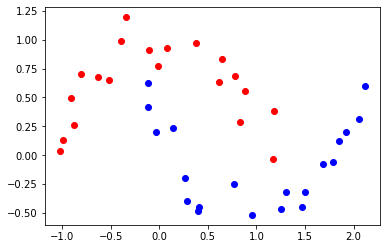

In [28]:
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

plt.show()

### 5.3.1 Training (Polynomial kernel)

In [29]:
# N is the number of training data points.
N = inputs.shape[0]

# Initialize the alpha vector with 0s.
start = np.zeros(N)

# Boundary conditions. Wihtout slack, there is only lower boundary.
B = [(0,None) for b in range(N)]

# Constraints.
XC = {'type':'eq', 'fun':zero_fun}

# Select the linear kernel for this simple problem.
kwargs = {"p": 3}
kernel = polynomial_kernel

# Pre-compute the constant part of the objective function.
pre_computed = pre_compute(inputs=inputs, targets=targets, kernel=kernel, **kwargs)

# Optimize the alphas.
ret = minimize(objective_func, start, bounds=B, constraints=XC)

# Assert if optimizer converged to a solution.
assert ret['success'] == True, "Failed to fit model. Try a more complex model or more slack for this complex data."

# Retrieve alpha.
alpha = ret["x"]

# Extract the support vectors, their targets, and alpha values. 
support_vecs, support_vec_targets, support_vec_alpha = reduce_comp(inputs, targets, alpha)
print(f"{support_vecs.shape[0]} support vectors have been found.")

7 support vectors have been found.


### 5.3.2 Visualizing the decision boundary and a new data point (Polynomial kernel)

Classifer: -3.415442116880852


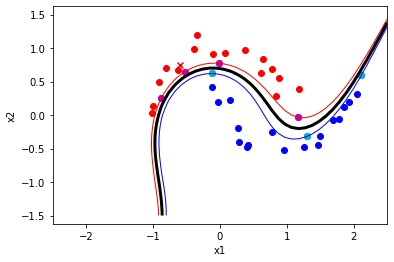

In [30]:
# Define new point and classify it using the indicator function.
new_input = np.array([-0.6, 0.75])
ind = indicator_func(new_input, support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
print(f"Classifer: {ind}")

# Set limits for the contour plot.
xlim = 2.5
ylim = 1.5

# Set the grid of the contour plot using the indicator function.
xgrid = np.linspace(-xlim, xlim)
ygrid = np.linspace(-ylim, ylim)
grid = np.array(
    [[indicator_func(np.array([x, y]), support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
    for x in xgrid] for y in ygrid])

# Plot the contour. classB (target is -1) is red, classA (target is 1) is blue.
plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

# Scatter plot the data.
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

# Retrive the support vectors for each class.
support_vecs_classA = support_vecs[support_vec_targets == 1]
support_vecs_classB = support_vecs[support_vec_targets == -1]

# Scatter plot the support vectors with the corresponding colours.
plt.scatter([p[0] for p in support_vecs_classA],[p[1] for p in support_vecs_classA], c="c", marker="o")
plt.scatter([p[0] for p in support_vecs_classB],[p[1] for p in support_vecs_classB], c="m", marker="o")

# Scatter plot the new data point with the correct colour.
plt.scatter(new_input[0], new_input[1], c="r" if ind < 0 else "b", marker="x", s=35)

# Set the axes to be of equal lenght.
plt.axis("equal")
plt.xlabel("x1")
plt.ylabel("x2")

# Save the figure.
#plt.savefig("svmplot.pdf")

# Plot the figure.
plt.show()

### 5.4.1 Training (RBF kernel)

In [31]:
# N is the number of training data points.
N = inputs.shape[0]

# Initialize the alpha vector with 0s.
start = np.zeros(N)

# Boundary conditions. Wihtout slack, there is only lower boundary.
B = [(0,None) for b in range(N)]

# Constraints.
XC = {'type':'eq', 'fun':zero_fun}

# Select the linear kernel for this simple problem.
kwargs = {"delta": 2}
kernel = radial_basis_function_kernel

# Pre-compute the constant part of the objective function.
pre_computed = pre_compute(inputs=inputs, targets=targets, kernel=kernel, **kwargs)

# Optimize the alphas.
ret = minimize(objective_func, start, bounds=B, constraints=XC)

# Assert if optimizer converged to a solution.
assert ret['success'] == True, "Failed to fit model. Try a more complex model or more slack for this complex data."

# Retrieve alpha.
alpha = ret["x"]

# Extract the support vectors, their targets, and alpha values. 
support_vecs, support_vec_targets, support_vec_alpha = reduce_comp(inputs, targets, alpha)
print(f"{support_vecs.shape[0]} support vectors have been found.")

19 support vectors have been found.


### 5.4.2 Visualizing the decision boundary and a new data point (RBF kernel)

Classifer: -1.166055770249967


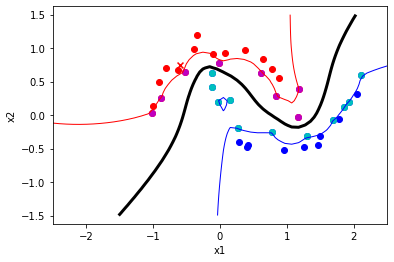

In [32]:
# Define new point and classify it using the indicator function.
new_input = np.array([-0.6, 0.75])
ind = indicator_func(new_input, support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
print(f"Classifer: {ind}")

# Set limits for the contour plot.
xlim = 2.5
ylim = 1.5

# Set the grid of the contour plot using the indicator function.
xgrid = np.linspace(-xlim, xlim)
ygrid = np.linspace(-ylim, ylim)
grid = np.array(
    [[indicator_func(np.array([x, y]), support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
    for x in xgrid] for y in ygrid])

# Plot the contour. classB (target is -1) is red, classA (target is 1) is blue.
plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

# Scatter plot the data.
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

# Retrive the support vectors for each class.
support_vecs_classA = support_vecs[support_vec_targets == 1]
support_vecs_classB = support_vecs[support_vec_targets == -1]

# Scatter plot the support vectors with the corresponding colours.
plt.scatter([p[0] for p in support_vecs_classA],[p[1] for p in support_vecs_classA], c="c", marker="o")
plt.scatter([p[0] for p in support_vecs_classB],[p[1] for p in support_vecs_classB], c="m", marker="o")

# Scatter plot the new data point with the correct colour.
plt.scatter(new_input[0], new_input[1], c="r" if ind < 0 else "b", marker="x", s=35)

# Set the axes to be of equal lenght.
plt.axis("equal")
plt.xlabel("x1")
plt.ylabel("x2")

# Save the figure.
#plt.savefig("svmplot.pdf")

# Plot the figure.
plt.show()

## 6. Another more difficult problem, more complex, linearly not separable data

### 6.1 Data generation

In [33]:
inputs, targets = datasets.make_circles(n_samples=40, factor=0.5, noise=0.05)
targets[targets == 0] = -1

classA = inputs[targets == 1]
classB = inputs[targets == -1]

### 6.2 Data visualization

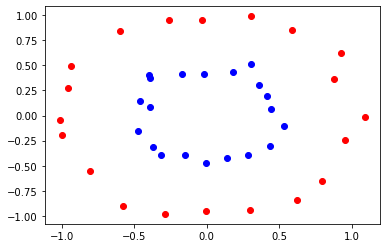

In [34]:
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

plt.show()

### 6.3.1 Training (polynomial kernel)

In [41]:
# N is the number of training data points.
N = inputs.shape[0]

# Initialize the alpha vector with 0s.
start = np.zeros(N)

# Boundary conditions. Wihtout slack, there is only lower boundary.
B = [(0,None) for b in range(N)]

# Constraints.
XC = {'type':'eq', 'fun':zero_fun}

# Select the linear kernel for this simple problem.
kwargs = {"p": 2}
kernel = radial_basis_function_kernel
kernel = polynomial_kernel

# Pre-compute the constant part of the objective function.
pre_computed = pre_compute(inputs=inputs, targets=targets, kernel=kernel, **kwargs)

# Optimize the alphas.
ret = minimize(objective_func, start, bounds=B, constraints=XC)

# Assert if optimizer converged to a solution.
assert ret['success'] == True, "Failed to fit model. Try a more complex model or more slack for this complex data."

# Retrieve alpha.
alpha = ret["x"]

# Extract the support vectors, their targets, and alpha values. 
support_vecs, support_vec_targets, support_vec_alpha = reduce_comp(inputs, targets, alpha)
print(f"{support_vecs.shape[0]} support vectors have been found.")

5 support vectors have been found.


### 6.3.2 Visualizing the decision boundary and a new data point (polynomial kernel)

Classifer: -1.0296551450347797


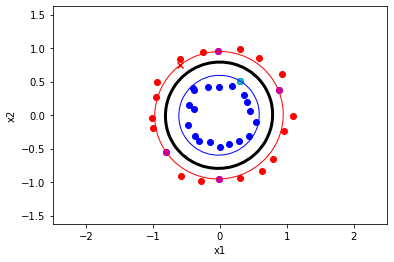

In [42]:
# Define new point and classify it using the indicator function.
new_input = np.array([-0.6, 0.75])
ind = indicator_func(new_input, support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
print(f"Classifer: {ind}")

# Set limits for the contour plot.
xlim = 2.5
ylim = 1.5

# Set the grid of the contour plot using the indicator function.
xgrid = np.linspace(-xlim, xlim)
ygrid = np.linspace(-ylim, ylim)
grid = np.array(
    [[indicator_func(np.array([x, y]), support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
    for x in xgrid] for y in ygrid])

# Plot the contour. classB (target is -1) is red, classA (target is 1) is blue.
plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

# Scatter plot the data.
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

# Retrive the support vectors for each class.
support_vecs_classA = support_vecs[support_vec_targets == 1]
support_vecs_classB = support_vecs[support_vec_targets == -1]

# Scatter plot the support vectors with the corresponding colours.
plt.scatter([p[0] for p in support_vecs_classA],[p[1] for p in support_vecs_classA], c="c", marker="o")
plt.scatter([p[0] for p in support_vecs_classB],[p[1] for p in support_vecs_classB], c="m", marker="o")

# Scatter plot the new data point with the correct colour.
plt.scatter(new_input[0], new_input[1], c="r" if ind < 0 else "b", marker="x", s=35)

# Set the axes to be of equal lenght.
plt.axis("equal")
plt.xlabel("x1")
plt.ylabel("x2")

# Save the figure.
#plt.savefig("svmplot.pdf")

# Plot the figure.
plt.show()

### 6.4.1 Training (RBF kernel)

In [43]:
# N is the number of training data points.
N = inputs.shape[0]

# Initialize the alpha vector with 0s.
start = np.zeros(N)

# Boundary conditions. Wihtout slack, there is only lower boundary.
B = [(0,None) for b in range(N)]

# Constraints.
XC = {'type':'eq', 'fun':zero_fun}

# Select the linear kernel for this simple problem.
kwargs = {"delta": 2}
kernel = radial_basis_function_kernel

# Pre-compute the constant part of the objective function.
pre_computed = pre_compute(inputs=inputs, targets=targets, kernel=kernel, **kwargs)

# Optimize the alphas.
ret = minimize(objective_func, start, bounds=B, constraints=XC)

# Assert if optimizer converged to a solution.
assert ret['success'] == True, "Failed to fit model. Try a more complex model or more slack for this complex data."

# Retrieve alpha.
alpha = ret["x"]

# Extract the support vectors, their targets, and alpha values. 
support_vecs, support_vec_targets, support_vec_alpha = reduce_comp(inputs, targets, alpha)
print(f"{support_vecs.shape[0]} support vectors have been found.")

28 support vectors have been found.


### 6.4.2 Visualizing the decision boundary and a new data point (polynomial kernel)

Classifer: -0.7391014192493719


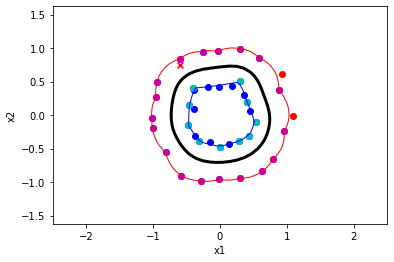

In [44]:
# Define new point and classify it using the indicator function.
new_input = np.array([-0.6, 0.75])
ind = indicator_func(new_input, support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
print(f"Classifer: {ind}")

# Set limits for the contour plot.
xlim = 2.5
ylim = 1.5

# Set the grid of the contour plot using the indicator function.
xgrid = np.linspace(-xlim, xlim)
ygrid = np.linspace(-ylim, ylim)
grid = np.array(
    [[indicator_func(np.array([x, y]), support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
    for x in xgrid] for y in ygrid])

# Plot the contour. classB (target is -1) is red, classA (target is 1) is blue.
plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

# Scatter plot the data.
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

# Retrive the support vectors for each class.
support_vecs_classA = support_vecs[support_vec_targets == 1]
support_vecs_classB = support_vecs[support_vec_targets == -1]

# Scatter plot the support vectors with the corresponding colours.
plt.scatter([p[0] for p in support_vecs_classA],[p[1] for p in support_vecs_classA], c="c", marker="o")
plt.scatter([p[0] for p in support_vecs_classB],[p[1] for p in support_vecs_classB], c="m", marker="o")

# Scatter plot the new data point with the correct colour.
plt.scatter(new_input[0], new_input[1], c="r" if ind < 0 else "b", marker="x", s=35)

# Set the axes to be of equal lenght.
plt.axis("equal")
plt.xlabel("x1")
plt.ylabel("x2")

# Save the figure.
#plt.savefig("svmplot.pdf")

# Plot the figure.
plt.show()

## 7. Very difficult problem, more complex, linearly not separable, noisy data

### 7.1 Data generation

In [64]:
inputs, targets = datasets.make_circles(n_samples=60, factor=0.4, noise=0.15)
targets[targets == 0] = -1

classA = inputs[targets == 1]
classB = inputs[targets == -1]

### 7.2 Data visualization

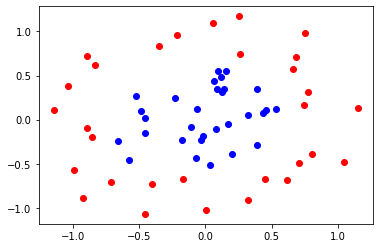

In [65]:
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

plt.show()

### 7.3.1 Training (polynomial kernel)

In [74]:
# N is the number of training data points.
N = inputs.shape[0]

# Initialize the alpha vector with 0s.
start = np.zeros(N)

# Boundary conditions. Wihtout slack, there is only lower boundary.
# Try with slack of 10 and None.
C = 10
B = [(0,C) for b in range(N)]

# Constraints.
XC = {'type':'eq', 'fun':zero_fun}

# Select the linear kernel for this simple problem.
kwargs = {"p": 2}
kernel = polynomial_kernel

# Pre-compute the constant part of the objective function.
pre_computed = pre_compute(inputs=inputs, targets=targets, kernel=kernel, **kwargs)

# Optimize the alphas.
ret = minimize(objective_func, start, bounds=B, constraints=XC)

# Assert if optimizer converged to a solution.
assert ret['success'] == True, "Failed to fit model. Try a more complex model or more slack for this complex data."

# Retrieve alpha.
alpha = ret["x"]

# Extract the support vectors, their targets, and alpha values. 
support_vecs, support_vec_targets, support_vec_alpha = reduce_comp(inputs, targets, alpha)
print(f"{support_vecs.shape[0]} support vectors have been found.")

13 support vectors have been found.


### 7.3.2 Visualizing the decision boundary and a new data point (polynomial kernel)

Classifer: -1.317707967992778


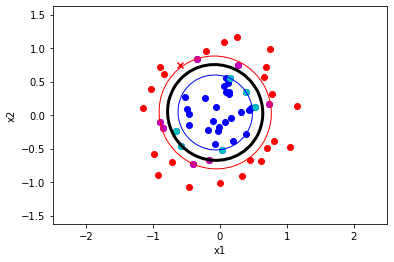

In [75]:
# Define new point and classify it using the indicator function.
new_input = np.array([-0.6, 0.75])
ind = indicator_func(new_input, support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
print(f"Classifer: {ind}")

# Set limits for the contour plot.
xlim = 2.5
ylim = 1.5

# Set the grid of the contour plot using the indicator function.
xgrid = np.linspace(-xlim, xlim)
ygrid = np.linspace(-ylim, ylim)
grid = np.array(
    [[indicator_func(np.array([x, y]), support_vecs, support_vec_targets, support_vec_alpha, kernel, **kwargs)
    for x in xgrid] for y in ygrid])

# Plot the contour. classB (target is -1) is red, classA (target is 1) is blue.
plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

# Scatter plot the data.
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c="b")
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c="r")

# Retrive the support vectors for each class.
support_vecs_classA = support_vecs[support_vec_targets == 1]
support_vecs_classB = support_vecs[support_vec_targets == -1]

# Scatter plot the support vectors with the corresponding colours.
plt.scatter([p[0] for p in support_vecs_classA],[p[1] for p in support_vecs_classA], c="c", marker="o")
plt.scatter([p[0] for p in support_vecs_classB],[p[1] for p in support_vecs_classB], c="m", marker="o")

# Scatter plot the new data point with the correct colour.
plt.scatter(new_input[0], new_input[1], c="r" if ind < 0 else "b", marker="x", s=35)

# Set the axes to be of equal lenght.
plt.axis("equal")
plt.xlabel("x1")
plt.ylabel("x2")

# Save the figure.
#plt.savefig("svmplot.pdf")

# Plot the figure.
plt.show()